# Personal Key Indicators of Heart Disease
Adrian-Paul CARRIERES Alice HIRON Amine ADDAJOU Alexandre HORVILLE

## Setup

### Libs

In [369]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

sns.set_style("white")  # change le style par défaut des graphiques seaborn
%matplotlib inline


### Load file

In [370]:
df = pd.read_csv("data/heart_2020_cleaned.csv")
df.head()


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


## Rebalancing data

In [371]:
df_heart_disease = df[df['HeartDisease'] == "Yes"]
df_no_heart_disease = df[df['HeartDisease'] == "No"]

drop_indices = np.random.choice(df_no_heart_disease.index, size=len(
    df_no_heart_disease)-len(df_heart_disease), replace=False)
df_no_heart_disease = df_no_heart_disease.drop(drop_indices)

df_new = pd.concat([df_heart_disease, df_no_heart_disease])
df = df_new
df_new.head()


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
5,Yes,28.87,Yes,No,No,6.0,0.0,Yes,Female,75-79,Black,No,No,Fair,12.0,No,No,No
10,Yes,34.30,Yes,No,No,30.0,0.0,Yes,Male,60-64,White,Yes,No,Poor,15.0,Yes,No,No
35,Yes,32.98,Yes,No,Yes,10.0,0.0,Yes,Male,75-79,White,Yes,Yes,Poor,4.0,No,No,Yes
42,Yes,25.06,No,No,No,0.0,0.0,Yes,Female,80 or older,White,Yes,No,Good,7.0,No,No,Yes
43,Yes,30.23,Yes,No,No,6.0,2.0,Yes,Female,75-79,White,Yes,Yes,Fair,8.0,No,Yes,No


## Clean dataframe

### Clean Yes/No to 1/0

In [372]:
column_to_change = ["HeartDisease", "Smoking", "AlcoholDrinking", "Stroke",
                    "DiffWalking", "Diabetic", "PhysicalActivity", "Asthma", "KidneyDisease", "SkinCancer"]
d = dict()
for c in column_to_change:
    d[c] = {"No": 0, "Yes": 1, "No, borderline diabetes": 2,
            "Yes (during pregnancy)": 3}
df = df.replace(d)
df.head()


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
5,1,28.87,1,0,0,6.0,0.0,1,Female,75-79,Black,0,0,Fair,12.0,0,0,0
10,1,34.30,1,0,0,30.0,0.0,1,Male,60-64,White,1,0,Poor,15.0,1,0,0
35,1,32.98,1,0,1,10.0,0.0,1,Male,75-79,White,1,1,Poor,4.0,0,0,1
42,1,25.06,0,0,0,0.0,0.0,1,Female,80 or older,White,1,0,Good,7.0,0,0,1
43,1,30.23,1,0,0,6.0,2.0,1,Female,75-79,White,1,1,Fair,8.0,0,1,0


### Change categoricals columns

In [373]:
#Without categorical data
heart_orig = df

In [374]:
# We can find 4 more categorical variables which are not yes/no. The dtype is object for these 4. Let us convert them into dummy variables.
categoricals = df.select_dtypes(include=['object'])
categoricals.head()
cat_dummies = pd.get_dummies(categoricals)
cat_dummies.head()
# Drop the redundant columns
df.drop(list(categoricals.columns), axis=1, inplace=True)
# concat the heart and dummies data frames.
df = pd.concat([df, cat_dummies], axis=1)
df.head(100)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Diabetic,PhysicalActivity,...,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good
5,1,28.87,1,0,0,6.0,0.0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
10,1,34.30,1,0,0,30.0,0.0,1,1,0,...,0,0,0,0,1,0,0,0,1,0
35,1,32.98,1,0,1,10.0,0.0,1,1,1,...,0,0,0,0,1,0,0,0,1,0
42,1,25.06,0,0,0,0.0,0.0,1,1,0,...,0,0,0,0,1,0,0,1,0,0
43,1,30.23,1,0,0,6.0,2.0,1,1,1,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656,1,30.34,1,0,0,3.0,5.0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
659,1,30.61,0,0,0,30.0,0.0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
667,1,24.28,0,0,0,0.0,0.0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
669,1,35.62,1,0,0,0.0,7.0,0,0,1,...,0,0,0,0,1,0,0,1,0,0


## Analyse

### Correlation

#### With categorical data splitted

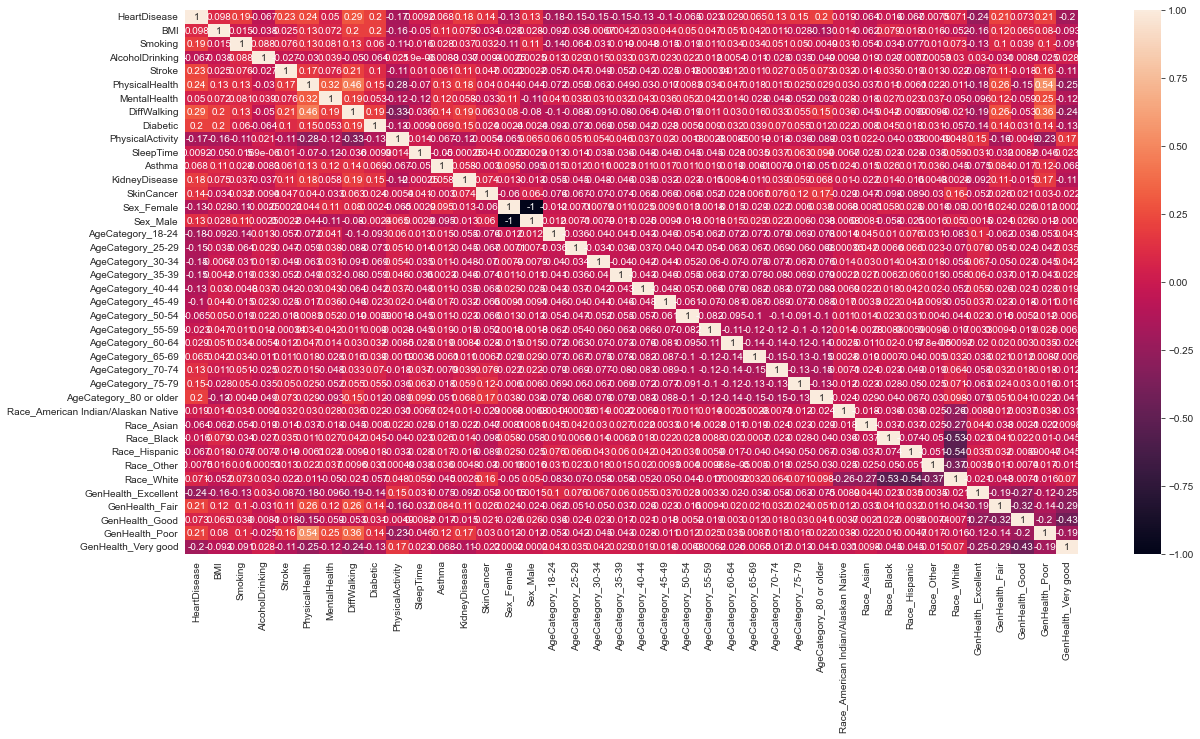

In [375]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(), annot=True)
plt.show()


#### Without categorical data

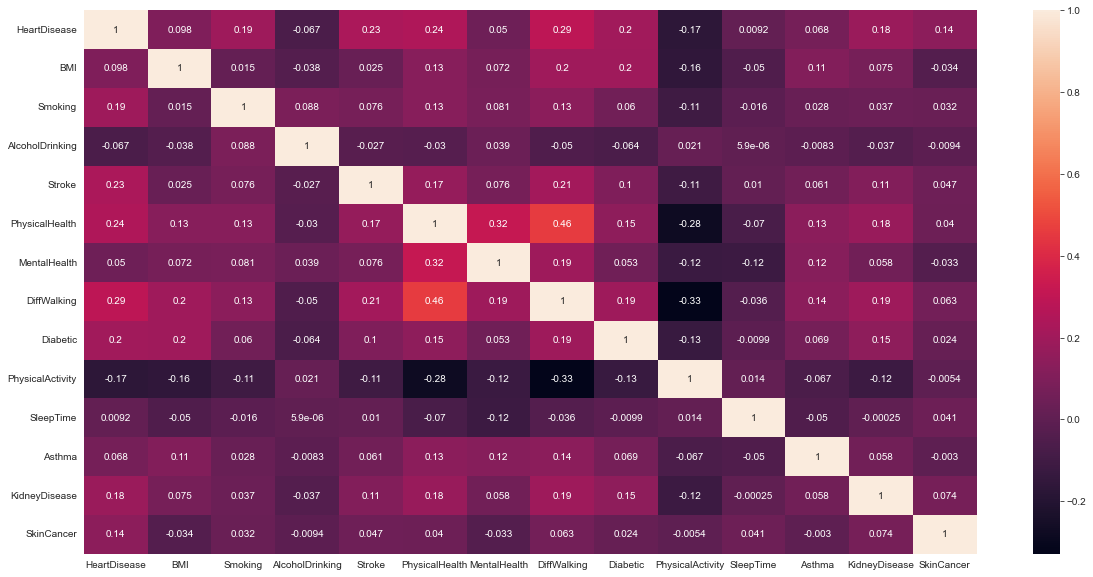

In [376]:
plt.figure(figsize=(20, 10))
sns.heatmap(heart_orig.corr(), annot=True)
plt.show()

## Setup for models

### Splitting dataset

In [377]:
# Here we are interested in the chance of having the heart disease based on other variables.
# Let y be HeartDisease column
y = df.pop('HeartDisease')
X = df
X.head()

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Diabetic,PhysicalActivity,SleepTime,...,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good
5,28.87,1,0,0,6.0,0.0,1,0,0,12.0,...,0,1,0,0,0,0,1,0,0,0
10,34.30,1,0,0,30.0,0.0,1,1,0,15.0,...,0,0,0,0,1,0,0,0,1,0
35,32.98,1,0,1,10.0,0.0,1,1,1,4.0,...,0,0,0,0,1,0,0,0,1,0
42,25.06,0,0,0,0.0,0.0,1,1,0,7.0,...,0,0,0,0,1,0,0,1,0,0
43,30.23,1,0,0,6.0,2.0,1,1,1,8.0,...,0,0,0,0,1,0,1,0,0,0


In [378]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, test_size=0.3, random_state=100)
X_train.head()

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Diabetic,PhysicalActivity,SleepTime,...,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good
258331,35.43,1,0,0,0.0,5.0,0,0,1,5.0,...,0,0,0,0,1,0,0,1,0,0
2462,34.67,1,0,1,0.0,0.0,1,1,1,7.0,...,0,0,0,0,1,0,0,1,0,0
281204,18.56,1,0,0,15.0,2.0,1,0,0,4.0,...,0,0,0,0,1,0,1,0,0,0
168857,30.18,0,0,0,0.0,0.0,0,1,1,7.0,...,0,0,0,0,1,0,0,1,0,0
139510,38.01,0,0,0,0.0,0.0,0,0,1,8.0,...,0,0,1,0,0,0,0,0,0,1


In [379]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, test_size=0.3, random_state=100)
X_train.head()

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Diabetic,PhysicalActivity,SleepTime,...,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good
258331,35.43,1,0,0,0.0,5.0,0,0,1,5.0,...,0,0,0,0,1,0,0,1,0,0
2462,34.67,1,0,1,0.0,0.0,1,1,1,7.0,...,0,0,0,0,1,0,0,1,0,0
281204,18.56,1,0,0,15.0,2.0,1,0,0,4.0,...,0,0,0,0,1,0,1,0,0,0
168857,30.18,0,0,0,0.0,0.0,0,1,1,7.0,...,0,0,0,0,1,0,0,1,0,0
139510,38.01,0,0,0,0.0,0.0,0,0,1,8.0,...,0,0,1,0,0,0,0,0,0,1


### Scale

In [380]:
# Scale X variables - should have done before spliting
from sklearn.preprocessing import scale

# rescale the features of Xtrain
cols = X_train.columns
X_train = pd.DataFrame(scale(X_train))
X_train.columns = cols

# rescale the features of Xtest
cols = X_test.columns
X_test = pd.DataFrame(scale(X_test))
X_test.columns = cols

## Not optimized models

In [381]:
accuracy_results = []
models = ["XGBoost with Bagging", "XGBoost with Boosting", "Decision Tree with Bagging", "Decision Tree with Boosting", "Naives Bayes", "Logistic Regression", "Random Forest"]

### XGBoost Classifier with Bagging and Boosting

In [382]:
import xgboost as xgb
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

# Init classifier
xgb_cl = xgb.XGBClassifier()

# The baggging ensemble classifier is initialized with:

bagging = BaggingClassifier(base_estimator=xgb_cl,
                            n_estimators=5, max_samples=50, bootstrap=True)

# Training
bagging.fit(X_train, y_train)

# Evaluating
print(f"Train score: {bagging.score(X_train, y_train)}")
print(f"Test score: {bagging.score(X_test, y_test)}")

# Fit
xgb_cl.fit(X_train, y_train)

# Predict
preds = xgb_cl.predict(X_test)

# Score
acc = accuracy_score(y_test, preds)
accuracy_results.append(acc)
print("Accuracy:", acc)


Train score: 0.6693283231564114
Test score: 0.6588528981977594
Accuracy: 0.7563930832927424


In [383]:
# Import scikit-learn metrics module for accuracy calculation
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics

# The base learner will be a decision tree with depth = 2
xgb_cl = xgb.XGBClassifier()

adaboost = AdaBoostClassifier(
    base_estimator=xgb_cl, n_estimators=5, learning_rate=0.1, random_state=23)

# Train!
adaboost.fit(X_train, y_train)

# Evaluation
print(f"Train score: {adaboost.score(X_train, y_train)}")
print(f"Test score: {adaboost.score(X_test, y_test)}")

# Fit
xgb_cl.fit(X_train, y_train)

# Predict
preds = xgb_cl.predict(X_test)

acc = metrics.accuracy_score(y_test, preds)
accuracy_results.append(acc)
print("Accuracy:", acc)

Train score: 0.49950420124210637
Test score: 0.5011568436434486
Accuracy: 0.7563930832927424


### Decision Tree Classifier with Bagging and Boosting

In [384]:
# Import Decision Tree Classifier
# Import scikit-learn metrics module for accuracy calculation
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import metrics

tree = DecisionTreeClassifier(max_depth=3, random_state=23)

# The baggging ensemble classifier is initialized with:

bagging = BaggingClassifier(
    base_estimator=tree, n_estimators=5, max_samples=50, bootstrap=True)

# Training
bagging.fit(X_train, y_train)

# Evaluating
print(f"Train score: {bagging.score(X_train, y_train)}")
print(f"Test score: {bagging.score(X_test, y_test)}")

# Train Decision Tree Classifer
tree = tree.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = tree.predict(X_test)

acc = metrics.accuracy_score(y_test, y_pred)
accuracy_results.append(acc)
print("Accuracy:", acc)


Train score: 0.6632221700328793
Test score: 0.652520701412567
Accuracy: 0.6906356551388212


In [385]:
from sklearn.ensemble import AdaBoostClassifier

# The base learner will be a decision tree with depth = 2
tree = DecisionTreeClassifier(max_depth=2, random_state=23)

adaboost = AdaBoostClassifier(
    base_estimator=tree, n_estimators=5, learning_rate=0.1, random_state=23)

# Train!
adaboost.fit(X_train, y_train)

# Evaluation
print(f"Train score: {adaboost.score(X_train, y_train)}")
print(f"Test score: {adaboost.score(X_test, y_test)}")

# Train Decision Tree Classifer
tree = tree.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = tree.predict(X_test)

acc = metrics.accuracy_score(y_test, y_pred)
accuracy_results.append(acc)
print("Accuracy:", acc)


Train score: 0.6841761912217525
Test score: 0.6819288845591817
Accuracy: 0.6678032148075986


### Naive Bayes Classifier

In [386]:
# Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

# Create a Gaussian Classifier
gnb = GaussianNB()

# Train the model using the training sets
gnb.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = gnb.predict(X_test)

acc = metrics.accuracy_score(y_test, y_pred)
accuracy_results.append(acc)
print("Accuracy:", acc)


Accuracy: 0.7397710667316123


### Logistic Regression

In [387]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

acc = metrics.accuracy_score(y_test, y_pred)
accuracy_results.append(acc)
print("Accuracy:", acc)


Accuracy: 0.7603507062834876


### Random Forest Classifier

Random Forest Train accuracy: 0.682 Test accuracy 0.676
Accuracy: 0.7563930832927424


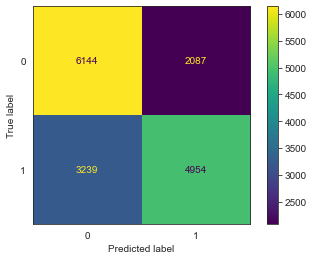

In [388]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

classifierRandomForest = RandomForestClassifier(
    max_depth=2, n_estimators=2, random_state=100, criterion='entropy')


def calculate_accuracy(classifier, X_train, X_test, y_train, y_test, modelName):
    classifier.fit(X_train, y_train)
    y_pred_train = classifier.predict(X_train)
    y_pred_test = classifier.predict(X_test)
    accuracy_train = metrics.accuracy_score(y_train, y_pred_train)
    accuracy_test = metrics.accuracy_score(y_test, y_pred_test)
    print(modelName, 'Train accuracy:', '{:.3f}'.format(
        accuracy_train), 'Test accuracy', '{:.3f}'.format(accuracy_test))
    return accuracy_train, accuracy_test, classifier


accuracy_train, accuracy_test, trained_classifier = calculate_accuracy(
    classifierRandomForest, X_train, X_test, y_train, y_test, modelName="Random Forest")
metrics.ConfusionMatrixDisplay.from_estimator(
    trained_classifier, X_test, y_test)

acc = metrics.accuracy_score(y_test, preds)
accuracy_results.append(acc)
print("Accuracy:", acc)

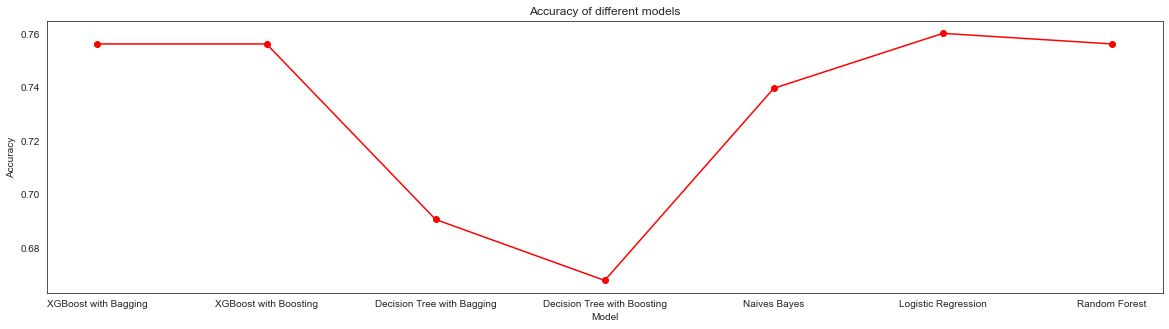

In [404]:
# Plot accuracy_results as x-axis and models as y-axis
plt.figure(figsize=(20, 5))
plt.plot(models, accuracy_results, 'o-', color='r', label='Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of different models')
plt.show()

## Using RFE

### Setting up RFE

In [390]:
# Let us use RFE to check required features and remove multicolearity
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Running RFE with the output number of the variable equal to 10
lm = LogisticRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm, n_features_to_select=30)             # running RFE
rfe = rfe.fit(X_train, y_train)

l = sorted(list(zip(X_train.columns,rfe.support_,rfe.ranking_)))

# sort l by rfe.ranking_
l.sort(key=lambda x: x[1], reverse=True)
l

[('AgeCategory_18-24', True, 1),
 ('AgeCategory_25-29', True, 1),
 ('AgeCategory_30-34', True, 1),
 ('AgeCategory_35-39', True, 1),
 ('AgeCategory_40-44', True, 1),
 ('AgeCategory_45-49', True, 1),
 ('AgeCategory_50-54', True, 1),
 ('AgeCategory_60-64', True, 1),
 ('AgeCategory_65-69', True, 1),
 ('AgeCategory_70-74', True, 1),
 ('AgeCategory_75-79', True, 1),
 ('AgeCategory_80 or older', True, 1),
 ('AlcoholDrinking', True, 1),
 ('Asthma', True, 1),
 ('BMI', True, 1),
 ('Diabetic', True, 1),
 ('DiffWalking', True, 1),
 ('GenHealth_Excellent', True, 1),
 ('GenHealth_Fair', True, 1),
 ('GenHealth_Good', True, 1),
 ('GenHealth_Poor', True, 1),
 ('GenHealth_Very good', True, 1),
 ('KidneyDisease', True, 1),
 ('MentalHealth', True, 1),
 ('PhysicalHealth', True, 1),
 ('Sex_Female', True, 1),
 ('Sex_Male', True, 1),
 ('SkinCancer', True, 1),
 ('Smoking', True, 1),
 ('Stroke', True, 1),
 ('AgeCategory_55-59', False, 5),
 ('PhysicalActivity', False, 10),
 ('Race_American Indian/Alaskan Native'

In [391]:
rfe_columns = X_train.columns[rfe.support_]
rfe_columns

Index(['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', 'PhysicalHealth',
       'MentalHealth', 'DiffWalking', 'Diabetic', 'Asthma', 'KidneyDisease',
       'SkinCancer', 'Sex_Female', 'Sex_Male', 'AgeCategory_18-24',
       'AgeCategory_25-29', 'AgeCategory_30-34', 'AgeCategory_35-39',
       'AgeCategory_40-44', 'AgeCategory_45-49', 'AgeCategory_50-54',
       'AgeCategory_60-64', 'AgeCategory_65-69', 'AgeCategory_70-74',
       'AgeCategory_75-79', 'AgeCategory_80 or older', 'GenHealth_Excellent',
       'GenHealth_Fair', 'GenHealth_Good', 'GenHealth_Poor',
       'GenHealth_Very good'],
      dtype='object')

In [392]:
# Creating X_train dataframe with RFE selected variables
X_train_rfe = X_train[rfe_columns]
X_train_rfe.head()

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Diabetic,Asthma,KidneyDisease,...,AgeCategory_60-64,AgeCategory_65-69,AgeCategory_70-74,AgeCategory_75-79,AgeCategory_80 or older,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good
0,1.036631,1.018862,-0.248983,-0.319918,-0.538730,0.093717,-0.563990,-0.527235,-0.428635,-0.290747,...,-0.355931,-0.384419,-0.393268,-0.336888,-0.389055,-0.401412,-0.462091,1.468650,-0.300506,-0.632409
1,0.918794,1.018862,-0.248983,3.125805,-0.538730,-0.494349,1.773081,1.318616,-0.428635,-0.290747,...,-0.355931,2.601331,-0.393268,-0.336888,-0.389055,-0.401412,-0.462091,1.468650,-0.300506,-0.632409
2,-1.579049,1.018862,-0.248983,-0.319918,0.965789,-0.259122,1.773081,-0.527235,2.332989,-0.290747,...,-0.355931,-0.384419,-0.393268,-0.336888,-0.389055,-0.401412,2.164076,-0.680898,-0.300506,-0.632409
3,0.222623,-0.981488,-0.248983,-0.319918,-0.538730,-0.494349,-0.563990,1.318616,-0.428635,3.439418,...,-0.355931,2.601331,-0.393268,-0.336888,-0.389055,-0.401412,-0.462091,1.468650,-0.300506,-0.632409
4,1.436658,-0.981488,-0.248983,-0.319918,-0.538730,-0.494349,-0.563990,-0.527235,-0.428635,-0.290747,...,-0.355931,-0.384419,-0.393268,-0.336888,-0.389055,-0.401412,-0.462091,-0.680898,-0.300506,1.581254


### Models using RFE

#### XGBoost Classifier with Bagging and Boosting


In [393]:
import xgboost as xgb
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

# Init classifier
xgb_cl = xgb.XGBClassifier()

# The baggging ensemble classifier is initialized with:

bagging = BaggingClassifier(base_estimator=xgb_cl,
                            n_estimators=5, max_samples=50, bootstrap=True)

# Training
bagging.fit(X_train, y_train)

# Evaluating
print(f"Train score: {bagging.score(X_train, y_train)}")
print(f"Test score: {bagging.score(X_test, y_test)}")

# Fit
xgb_cl.fit(X_train, y_train)

# Predict
preds = xgb_cl.predict(X_test)

# Score
accuracy_score(y_test, preds)


Train score: 0.6741036480350713
Test score: 0.6691427179736971


0.7563930832927424

In [394]:
# Import scikit-learn metrics module for accuracy calculation
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics

# The base learner will be a decision tree with depth = 2
xgb_cl = xgb.XGBClassifier()

adaboost = AdaBoostClassifier(
    base_estimator=xgb_cl, n_estimators=5, learning_rate=0.1, random_state=23)

# Train!
adaboost.fit(X_train, y_train)

# Evaluation
print(f"Train score: {adaboost.score(X_train, y_train)}")
print(f"Test score: {adaboost.score(X_test, y_test)}")

# Fit
xgb_cl.fit(X_train, y_train)

# Predict
preds = xgb_cl.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, preds))


Train score: 0.49950420124210637
Test score: 0.5011568436434486
Accuracy: 0.7563930832927424


#### Decision Tree Classifier with Bagging and Boosting

In [395]:
# Import Decision Tree Classifier
# Import scikit-learn metrics module for accuracy calculation
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import metrics

tree = DecisionTreeClassifier(max_depth=3, random_state=23)

# The baggging ensemble classifier is initialized with:

bagging = BaggingClassifier(
    base_estimator=tree, n_estimators=5, max_samples=50, bootstrap=True)

# Training
bagging.fit(X_train, y_train)

# Evaluating
print(f"Train score: {bagging.score(X_train, y_train)}")
print(f"Test score: {bagging.score(X_test, y_test)}")

# Train Decision Tree Classifer
tree = tree.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = tree.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))


Train score: 0.6871509837691143
Test score: 0.6885655138821237
Accuracy: 0.6906356551388212


In [396]:
from sklearn.ensemble import AdaBoostClassifier

# The base learner will be a decision tree with depth = 2
tree = DecisionTreeClassifier(max_depth=2, random_state=23)

adaboost = AdaBoostClassifier(
    base_estimator=tree, n_estimators=5, learning_rate=0.1, random_state=23)

# Train!
adaboost.fit(X_train, y_train)

# Evaluation
print(f"Train score: {adaboost.score(X_train, y_train)}")
print(f"Test score: {adaboost.score(X_test, y_test)}")

# Train Decision Tree Classifer
tree = tree.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = tree.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))


Train score: 0.6841761912217525
Test score: 0.6819288845591817
Accuracy: 0.6678032148075986


#### Naive Bayes Classifier

In [397]:
# Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

# Create a Gaussian Classifier
gnb = GaussianNB()

# Train the model using the training sets
gnb.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = gnb.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.7397710667316123


#### Logistic Regression

In [398]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print("Accuracy : ", accuracy_score(y_test, y_pred))


Accuracy :  0.7603507062834876


#### Random Forest Classifier

Random Forest Train accuracy: 0.682 Test accuracy 0.676


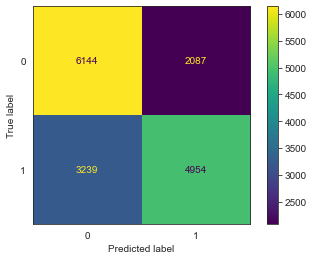

In [399]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

classifierRandomForest = RandomForestClassifier(
    max_depth=2, n_estimators=2, random_state=100, criterion='entropy')


def calculate_accuracy(classifier, X_train, X_test, y_train, y_test, modelName):
    classifier.fit(X_train, y_train)
    y_pred_train = classifier.predict(X_train)
    y_pred_test = classifier.predict(X_test)
    accuracy_train = metrics.accuracy_score(y_train, y_pred_train)
    accuracy_test = metrics.accuracy_score(y_test, y_pred_test)
    print(modelName, 'Train accuracy:', '{:.3f}'.format(
        accuracy_train), 'Test accuracy', '{:.3f}'.format(accuracy_test))
    return accuracy_train, accuracy_test, classifier


accuracy_train, accuracy_test, trained_classifier = calculate_accuracy(
    classifierRandomForest, X_train, X_test, y_train, y_test, modelName="Random Forest")
metrics.ConfusionMatrixDisplay.from_estimator(
    trained_classifier, X_test, y_test)
